# Imports

In [19]:
import os
import json
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import re
from PIL import Image
import pickle
import numpy as np
from sklearn.metrics import roc_curve, auc
import copy
from sklearn.metrics import classification_report, precision_recall_curve, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from bertopic import BERTopic


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model

# Machine Learning Results

In [20]:
BASE_DIR = "results"
records = []
for root, dirs, files in os.walk(BASE_DIR):
    if "accuracy_report.json" in files:
        json_path = os.path.join(root, "accuracy_report.json")
        
        # Load JSON data
        with open(json_path, "r") as f:
            data = json.load(f)
        
        # Extract core metrics
        model_name = data.get("model", os.path.basename(root))
        train_acc = data.get("train_accuracy")
        test_acc = data.get("test_accuracy")
        train_time = data.get("train_time_sec")
        
        # Extract key summary metrics from classification_report
        clf_rep = data.get("classification_report", {})
        macro_avg = clf_rep.get("macro avg", {})
        weighted_avg = clf_rep.get("weighted avg", {})
        
        record = {
            "model": model_name,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_time_sec": train_time,
            "macro_precision": macro_avg.get("precision"),
            "macro_recall": macro_avg.get("recall"),
            "macro_f1": macro_avg.get("f1-score"),
            "weighted_precision": weighted_avg.get("precision"),
            "weighted_recall": weighted_avg.get("recall"),
            "weighted_f1": weighted_avg.get("f1-score"),
        }
        
        records.append(record)

# Convert to DataFrame
df_results = pd.DataFrame(records)

# Optional: sort by test accuracy
df_results = df_results.sort_values(by="test_accuracy", ascending=False).reset_index(drop=True)

In [21]:
df_results

,model,train_accuracy,test_accuracy,train_time_sec,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,Logistic Regression,0.936926,0.922071,1.191897,0.655514,0.473361,0.514797,0.894690,0.922071,0.900659
1,balanced_tuning_svm,0.939916,0.921136,2.938524,0.624356,0.459283,0.490463,0.887827,0.921136,0.896389
2,Linear SVM,0.961735,0.919922,1.939387,0.621421,0.502267,0.538007,0.895436,0.919922,0.903851
3,Naive Bayes,0.917467,0.914222,0.010373,0.678178,0.380707,0.399616,0.882183,0.914222,0.878907
4,balanced_tuning_logreg,0.942054,0.908475,1.039648,0.584502,0.587756,0.586067,0.908281,0.908475,0.908370
5,balanced_tuning_logreg_ros,0.909501,0.847692,6.852488,0.507961,0.622730,0.542236,0.910496,0.847692,0.873961
6,balanced_tuning_complementnb,0.854521,0.823818,0.000000,0.477198,0.644741,0.514542,0.910946,0.823818,0.857364
7,tuned_svm,0.820218,0.668079,0.024605,0.665461,0.668079,0.665535,0.665461,0.668079,0.665535
8,Naive_Bayes_BALANCED,0.820521,0.665960,0.010997,0.664710,0.665960,0.665101,0.664710,0.665960,0.665101
9,tuned_nb,0.803571,0.664548,0.002998,0.664087,0.664548,0.663974,0.664087,0.664548,0.663974


In [22]:
# --- Top 3 based on Macro F1-score ---
top3_macro_f1 = (
    df_results.sort_values(by="macro_f1", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Macro F1-score:")
print(top3_macro_f1[["model", "macro_f1", "test_accuracy"]])
print()

# --- Top 3 based on Test Accuracy ---
top3_accuracy = (
    df_results.sort_values(by="test_accuracy", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Test Accuracy:")
print(top3_accuracy[["model", "test_accuracy", "macro_f1"]])


Top 3 Models by Macro F1-score:
                  model  macro_f1  test_accuracy
0             tuned_svm  0.665535       0.668079
1  Naive_Bayes_BALANCED  0.665101       0.665960
2              tuned_nb  0.663974       0.664548

Top 3 Models by Test Accuracy:
                 model  test_accuracy  macro_f1
0  Logistic Regression       0.922071  0.514797
1  balanced_tuning_svm       0.921136  0.490463
2           Linear SVM       0.919922  0.538007


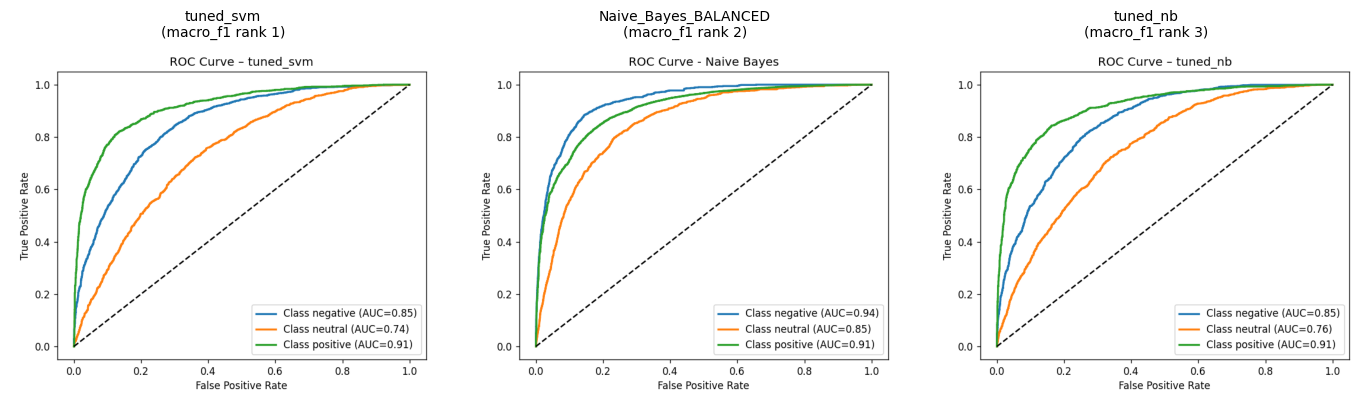

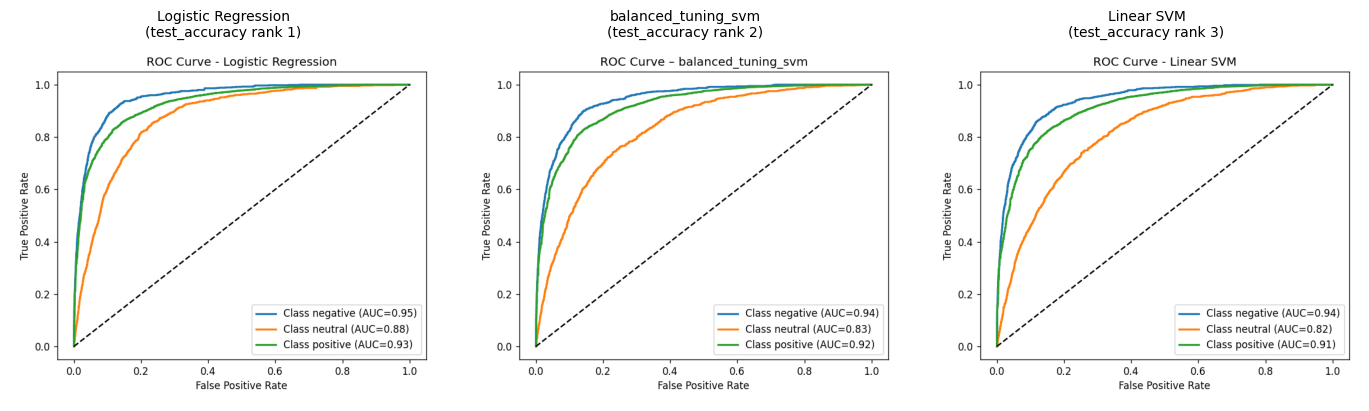

In [23]:
def find_model_folder(base_dir, model_name):
    """
    Try to locate a folder inside base_dir that best matches model_name,
    ignoring case and underscores.
    """
    norm_model = re.sub(r'[_\W]+', '', model_name).lower()
    for folder in os.listdir(base_dir):
        norm_folder = re.sub(r'[_\W]+', '', folder).lower()
        if norm_model in norm_folder or norm_folder in norm_model:
            return os.path.join(base_dir, folder)
    return None


def show_roc_curves(df, base_dir="results", sort_by="macro_f1", top_n=3):
    """
    Display ROC curve images for top models with flexible folder matching.
    """
    top_models = (
        df.sort_values(by=sort_by, ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    plt.figure(figsize=(14, 4))
    for i, model_name in enumerate(top_models["model"], 1):
        folder_path = find_model_folder(base_dir, model_name)
        roc_path = None
        if folder_path:
            possible_path = os.path.join(folder_path, "roc_curve.png")
            if os.path.exists(possible_path):
                roc_path = possible_path
        
        plt.subplot(1, top_n, i)
        if roc_path:
            img = mpimg.imread(roc_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)
        else:
            plt.text(0.5, 0.5, "ROC not found", ha="center", va="center")
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)
    
    plt.tight_layout()
    plt.show()


# Example usage
show_roc_curves(df_results, base_dir="results", sort_by="macro_f1", top_n=3)
show_roc_curves(df_results, base_dir="results", sort_by="test_accuracy", top_n=3)

Notice that the classes with the best macro-f1 score had lower AUC scores across the board than the models with with higher test accuracy except for the Naive Bayes class that was balanced, however the test accuracy for these were about 66% while the high-test accuracy models had about 92% accuracy but macro f1-scores were ranging from about 59-54%. This aligns theoretically with class imbalances being dealt with because ROC-AUC is mostly class invariant to balance of classes because it relies on TPR and FPR which is just rates for true positive rate and false positive rate. 

It's possible that high accuracy models have dominantly predicted the majority class and this is why the macro f1-score is so important because it emphasizes the performance of the minority classes as these now have equal importance on dragging down the f1 score.

But the ROC-AUC is still important because it illustrates the sensitivity vs specificity trade-off per class, a steep rise in the y-axis of the class shows good separability, whereas the flatter curves might represent overlapping probability distributions between classes. Furthermore, the ROC-AUC graph may also show how tuning and balancing different models compares the difference between discrimination between classes, i.e., did it favour the discrimination of the positive class or the negative class? Looking at the graphs the Linear SVM had a higher AUC for negative class at 0.94, but the tuned_svm had a higher positive class at 0.91.

# Deep Learning Models

In [24]:
BASE_DIR = "outputs_colab"

records = []

# Walk through all subfolders in outputs_colab
for root, dirs, files in os.walk(BASE_DIR):
    for file in files:
        if file.endswith("_classification_report.json"):
            json_path = os.path.join(root, file)
            
            # Load JSON
            with open(json_path, "r") as f:
                data = json.load(f)

            # Extract model name from filename (e.g. "bert_lstm_gelu")
            model_name = file.replace("_classification_report.json", "")
            
            # Core metrics
            accuracy = data.get("accuracy")
            macro = data.get("macro avg", {})
            weighted = data.get("weighted avg", {})

            # Optional: extract per-class metrics (0,1,2)
            neg = data.get("0", {})
            neu = data.get("1", {})
            pos = data.get("2", {})

            records.append({
                "model": model_name,
                "accuracy": accuracy,
                "macro_precision": macro.get("precision"),
                "macro_recall": macro.get("recall"),
                "macro_f1": macro.get("f1-score"),
                "weighted_precision": weighted.get("precision"),
                "weighted_recall": weighted.get("recall"),
                "weighted_f1": weighted.get("f1-score"),
                "neg_f1": neg.get("f1-score"),
                "neu_f1": neu.get("f1-score"),
                "pos_f1": pos.get("f1-score")
            })

# Create DataFrame
df_dl_results = pd.DataFrame(records)

# Sort by macro-F1 descending
df_dl_results = df_dl_results.sort_values(by="macro_f1", ascending=False).reset_index(drop=True)

In [25]:
df_dl_results

,model,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,neg_f1,neu_f1,pos_f1
0,roberta-gru-gelu,0.908304,0.649069,0.750009,0.682263,0.941789,0.908304,0.921907,0.682003,0.404218,0.960567
1,roberta_lstm_gelu,0.906310,0.645737,0.746251,0.678844,0.941223,0.906310,0.920607,0.689980,0.386900,0.959653
2,bert-gru-,0.909051,0.642906,0.738440,0.676572,0.939316,0.909051,0.921612,0.679547,0.389016,0.961154
3,bert-rnn-gelu,0.910733,0.635337,0.740238,0.675802,0.937240,0.910733,0.921805,0.686361,0.379512,0.961532
4,roberta-rnn-gelu,0.898025,0.644465,0.756420,0.675792,0.942862,0.898025,0.915824,0.682192,0.390613,0.954571
5,bert_lstm_gelu,0.902386,0.637984,0.738966,0.671293,0.938631,0.902386,0.917303,0.683578,0.373264,0.957038
6,roberta-cnn-gelu,0.894101,0.640310,0.743410,0.667160,0.941165,0.894101,0.912964,0.676859,0.371966,0.952655
7,roberta_bi_lstm_gelu,0.894911,0.630970,0.747597,0.667010,0.939306,0.894911,0.912830,0.680711,0.367779,0.952540
8,bert_bi_lstm_gelu,0.904255,0.627165,0.734332,0.666093,0.936568,0.904255,0.917676,0.671765,0.368228,0.958285
9,bert-cnn-gelu,0.907494,0.626338,0.731532,0.666079,0.936532,0.907494,0.919640,0.669182,0.368496,0.960557


In [26]:
# --- Top 3 based on Macro F1 ---
top3_macro_f1 = (
    df_dl_results.sort_values(by="macro_f1", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Macro F1-score:")
print(top3_macro_f1[["model", "macro_f1", "accuracy"]])
print()

# --- Top 3 based on Accuracy ---
top3_accuracy = (
    df_dl_results.sort_values(by="accuracy", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Accuracy:")
print(top3_accuracy[["model", "accuracy", "macro_f1"]])


Top 3 Models by Macro F1-score:
               model  macro_f1  accuracy
0   roberta-gru-gelu  0.682263  0.908304
1  roberta_lstm_gelu  0.678844  0.906310
2          bert-gru-  0.676572  0.909051

Top 3 Models by Accuracy:
              model  accuracy  macro_f1
0     bert-rnn-gelu  0.910733  0.675802
1         bert-gru-  0.909051  0.676572
2  roberta-gru-gelu  0.908304  0.682263


As compared to the more basic machine learning models, the macro F1-score and accuracy are much more consistent for the deep learning models. We are now gettting slightly lower accuracy but much better macro-f1 scores with regards to maintaining accuracy. This means that the models are better discriminating the minority classes. 

This might also hint at better generalization and it definitely shows better minority class discrimination. Which might create a more fair model across class distributions

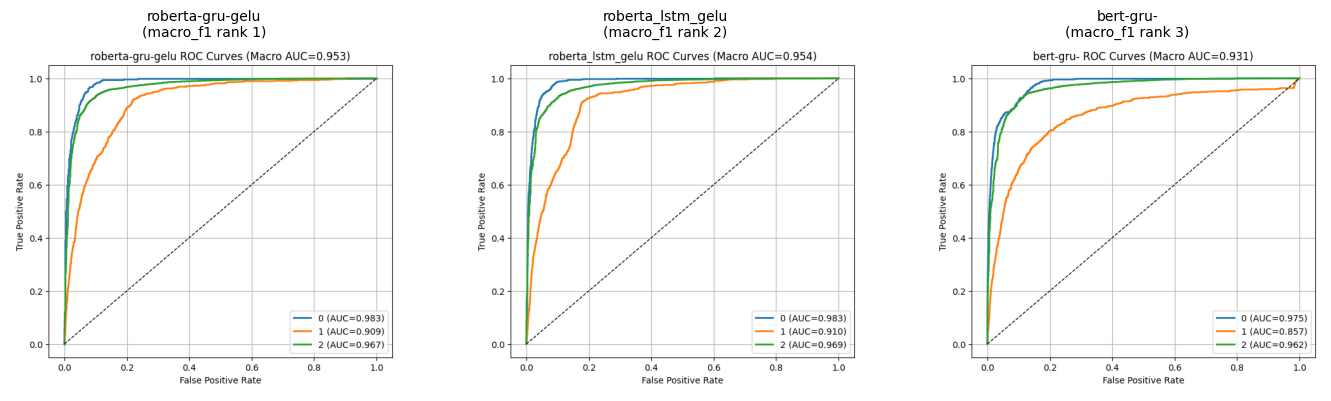

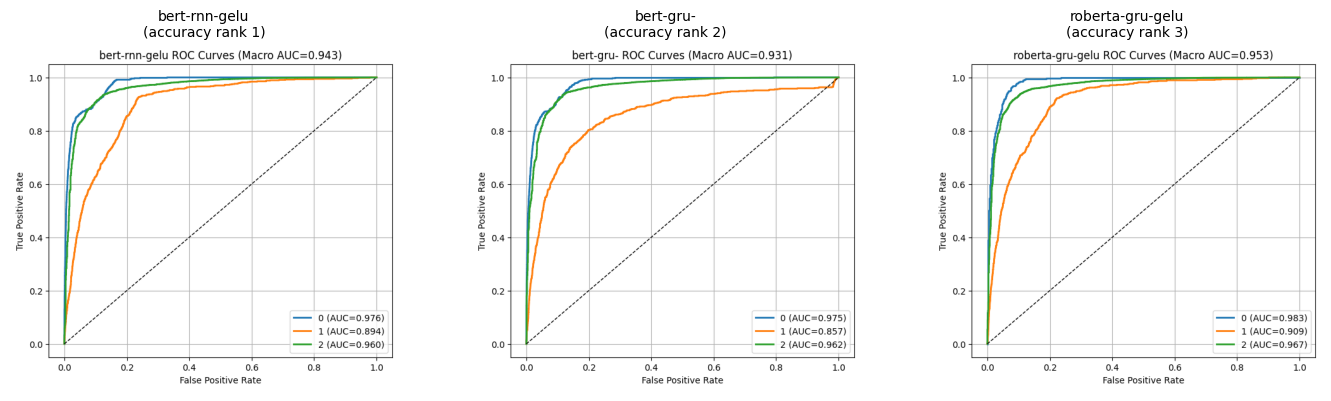

In [27]:
def find_model_image(base_dir, model_name):
    """
    Try to locate the ROC-AUC image file for a model (case-insensitive, underscore-insensitive).
    Matches filenames containing both the model name and 'roc_auc'.
    """
    norm_model = re.sub(r'[_\W]+', '', model_name).lower()
    for root, _, files in os.walk(base_dir):
        for f in files:
            norm_file = re.sub(r'[_\W]+', '', f).lower()
            if 'rocauc' in norm_file and norm_model in norm_file:
                return os.path.join(root, f)
    return None


def show_roc_curves(df, base_dir, sort_by="macro_f1", top_n=3):
    """
    Display ROC–AUC images for the top models based on a given metric.
    """
    top_models = (
        df.sort_values(by=sort_by, ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    plt.figure(figsize=(14, 4))
    for i, model_name in enumerate(top_models["model"], 1):
        img_path = find_model_image(base_dir, model_name)
        plt.subplot(1, top_n, i)
        if img_path and os.path.exists(img_path):
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)
        else:
            plt.text(0.5, 0.5, "ROC image not found", ha="center", va="center")
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)

    plt.tight_layout()
    plt.show()


# --- Plot ROC curves for top 3 by macro-F1 ---
show_roc_curves(df_dl_results, base_dir=BASE_DIR, sort_by="macro_f1", top_n=3)

# --- Plot ROC curves for top 3 by accuracy ---
show_roc_curves(df_dl_results, base_dir=BASE_DIR, sort_by="accuracy", top_n=3)

In addition to the stronger macro-F1 performance, the deep learning models also demonstrate markedly higher AUC-ROC values across all classes. This indicates that these models achieve better overall separability between positive and negative decision boundaries at every possible classification threshold. The smoother and steeper ROC curves suggest that the learned feature representations, particularly through transformer-based embeddings combined with recurrent layers-enable the models to capture more nuanced contextual relationships in the text. Consequently, they can more confidently distinguish between sentiment classes, achieving both higher discriminative power and more stable behaviour across thresholds compared to the baseline machine-learning models.

Why might the ROC-AUC graphs be important here? This is important because the model threhsolds could be adjusted to capture more negatives without decreasing the precision of the model too much. However, the neutral class seems to be failing quite a bit, this isn't too concerning because neutral reviews tend to convey less semantic meaning and tend to not be as informative as a polarized review, however it is still possible to gain some information from neutral reviews. 

In the context of changing educational paedagogy it might be important to note that the separability of the negative class might be more important because we might want to actually prioritize the classification of the negative class because this identifies pain points of students/staff members regarding modules/subjects or processes. This is actionable insight in which thew institution can then make changes towards rectifying.

Timings for training inference 100k rows on l4 gpu {'total_time_sec': 335.12440299987793, 'time_per_sample_sec': 0.0031314769758347, 'time_per_batch_sec': 0.4003875782555292} at 1.71 compute units p/hr

# Deep Dive Into roberta-bigru-lr-adj

Loaded → classification report: True
Loaded → config: True
Loaded → timing: True


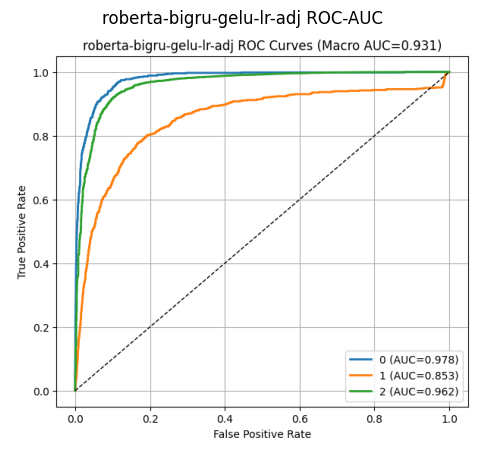

Macro-F1: 0.6938024589870576
Accuracy: 0.9259328474428455


In [28]:
# MODEL TAG
BIGRU = "roberta-bigru-gelu-lr-adj"
BASE = f"outputs_colab_final/{BIGRU}"

# --- Load JSON files ---
BIGRU_classification_report = None
BIGRU_config = None
BIGRU_timing_log = None

for f in os.listdir(BASE):
    path = os.path.join(BASE, f)

    if f.endswith("classification_report.json"):
        with open(path, "r") as jf:
            BIGRU_classification_report = json.load(jf)

    elif f.endswith("config.json"):
        with open(path, "r") as jf:
            BIGRU_config = json.load(jf)

    elif f.endswith("timing_log.json"):
        with open(path, "r") as jf:
            BIGRU_timing_log = json.load(jf)

print("Loaded → classification report:", BIGRU_classification_report is not None)
print("Loaded → config:", BIGRU_config is not None)
print("Loaded → timing:", BIGRU_timing_log is not None)


# --- Load images ---
BIGRU_roc_img = None
BIGRU_graphs = {}

for f in os.listdir(BASE):
    path = os.path.join(BASE, f)

    if f.endswith(".png") and "roc_auc" in f:
        BIGRU_roc_img = Image.open(path)

    # training loss, accuracy, general graphs
    if f.endswith(".png") and any(x in f for x in ["graph", "training"]):
        BIGRU_graphs[f] = Image.open(path)


# --- Display ROC curve ---
if BIGRU_roc_img:
    plt.figure(figsize=(6,6))
    plt.imshow(BIGRU_roc_img)
    plt.axis("off")
    plt.title(f"{BIGRU} ROC-AUC")
    plt.show()
else:
    print("No ROC-AUC image found.")

# --- Print metrics ---
if BIGRU_classification_report:
    BIGRU_macro_f1 = BIGRU_classification_report["macro avg"]["f1-score"]
    BIGRU_accuracy = BIGRU_classification_report.get("accuracy")

    print("Macro-F1:", BIGRU_macro_f1)
    print("Accuracy:", BIGRU_accuracy)

In [29]:
BASE = "outputs_colab_final/roberta-bigru-gelu-lr-adj"
PRED_FILE = os.path.join(BASE, "roberta-bigru-gelu-lr-adj_predictions.pkl")

with open(PRED_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['y_true_idx', 'y_pred_idx', 'y_true', 'y_pred', 'probs', 'class_names'])

In [30]:
y_true_idx = data["y_true_idx"]
y_pred_idx = data["y_pred_idx"]

y_true = data["y_true"]
y_pred = data["y_pred"]

probs = data["probs"]
class_names = data["class_names"]

y_true_idx = np.array(y_true_idx)
y_pred_idx = np.array(y_pred_idx)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

probs = np.array(probs)
class_names = np.array(class_names)


In [31]:
df = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "y_true_idx": y_true_idx,
    "y_pred_idx": y_pred_idx
})

df.head()

,y_true,y_pred,y_true_idx,y_pred_idx
0,2,2,2,2
1,2,2,2,2
2,2,2,2,2
3,2,2,2,2
4,2,2,2,2


In [32]:
for i, cname in enumerate(class_names):
    df[f"prob_{cname}"] = probs[:, i]

df.head()

,y_true,y_pred,y_true_idx,y_pred_idx,prob_0,prob_1,prob_2
0,2,2,2,2,1.069040e-06,0.000059,0.999940
1,2,2,2,2,7.983578e-07,0.000076,0.999923
2,2,2,2,2,7.946463e-07,0.000118,0.999881
3,2,2,2,2,2.400549e-06,0.000049,0.999948
4,2,2,2,2,2.792731e-05,0.006909,0.993064


In [33]:
print("Unique preds:", np.unique(y_pred_idx))


Unique preds: [0 1 2]


In [34]:
# ==========================
# 1) Load data
# ==========================
df = pd.read_csv("data/reviews.csv")   # <-- adjust path if needed

# EXPECTED columns: "text", "label"
X = df["Review"].values
y = df["Label"].values

# ==========================
# 2) Split train/temp
# ==========================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.7, random_state=42, stratify=y
)

# ==========================
# 3) Split temp -> val/test
# ==========================
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# ==========================
# 4) Label encode consistently
# ==========================
label_enc = LabelEncoder()
label_enc.fit(list(y_train) + list(y_val) + list(y_test))

y_train_enc = label_enc.transform(y_train)
y_val_enc   = label_enc.transform(y_val)
y_test_enc  = label_enc.transform(y_test)

print("Train size:", len(X_train))
print("Val size:  ", len(X_val))
print("Test size: ", len(X_test))
print("Classes found:", label_enc.classes_)
print("Unique y_test_enc:", pd.Series(y_test_enc).unique())


Train size: 74912
Val size:   16053
Test size:  16053
Classes found: [1 2 3 4 5]
Unique y_test_enc: [3 4 2 0 1]


Unique true 3-class: [0 1 2]
Unique pred 3-class: [0 1 2]


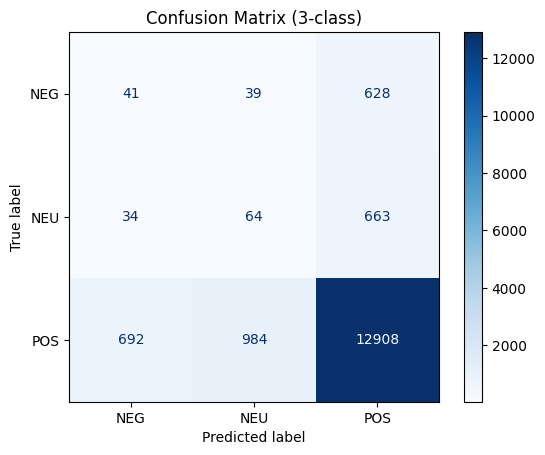

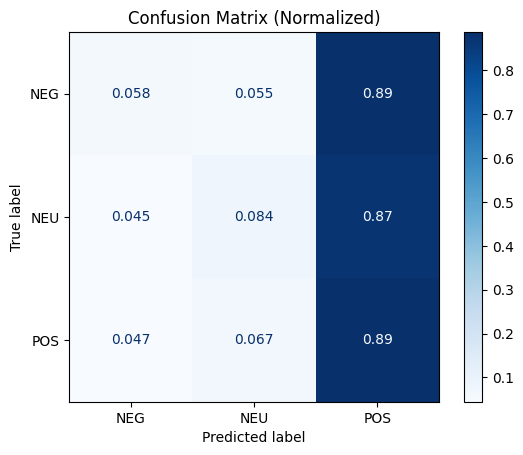

In [35]:
# =======================================
# 1) Remap TRUE labels 5-class → 3-class
# =======================================
# 0,1 --> NEG (0)
# 2   --> NEU (1)
# 3,4 --> POS (2)

map_5to3 = {
    0: 0,
    1: 0,
    2: 1,
    3: 2,
    4: 2
}

y_test_3 = np.array([map_5to3[x] for x in y_test_enc])

# =======================================
# 2) Predictions are ALREADY 0/1/2
#    → use directly
# =======================================
y_pred_3 = y_pred_idx

print("Unique true 3-class:", np.unique(y_test_3))
print("Unique pred 3-class:", np.unique(y_pred_3))


# =======================================
# 3) Confusion Matrix
# =======================================
labels3 = ["NEG", "NEU", "POS"]
cm = confusion_matrix(y_test_3, y_pred_3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels3)
disp.plot(values_format='d', cmap="Blues")
plt.title("Confusion Matrix (3-class)")
plt.show()

# =======================================
# 4) Normalized version
# =======================================
cm_norm = confusion_matrix(y_test_3, y_pred_3, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels3)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Normalized)")
plt.show()

## ROC-AUC Optimization of Negative Class

In [36]:
for i, c in enumerate(class_names):
    print(i, repr(c))


0 np.int64(0)
1 np.int64(1)
2 np.int64(2)


In [37]:
neg_idx = 0

neg_probs = probs[:, neg_idx]
y_true_binary = (y_true_idx == neg_idx).astype(int)

fpr, tpr, thresholds = roc_curve(y_true_binary, neg_probs)
roc_auc = auc(fpr, tpr)

J = tpr - fpr
best_idx = np.argmax(J)
best_threshold = thresholds[best_idx]

best_threshold


np.float64(6.289861630648375e-05)

In [38]:
y_pred_idx_opt = copy.copy(y_pred_idx)

for i in range(len(y_pred_idx_opt)):
    if neg_probs[i] >= best_threshold:
        y_pred_idx_opt[i] = neg_idx

In [39]:
print(classification_report(y_true_idx, y_pred_idx_opt, digits=4))

              precision    recall  f1-score   support

           0     0.2813    0.9675    0.4359       708
           1     0.3381    0.1248    0.1823       761
           2     0.9878    0.9033    0.9437     14584

    accuracy                         0.8692     16053
   macro avg     0.5357    0.6652    0.5206     16053
weighted avg     0.9258    0.8692    0.8852     16053



We have optimized for negative class being detected at all costs, i.e. we almost never miss a negative review when it is negative, but we are now dropping the precision as we are now aggressively classifgying negative so more positive and neutral reviews may be falsely classified as negative.

=== Baseline (no threshold) ===
              precision    recall  f1-score   support

         NEG     0.0535    0.0579    0.0556       708
         NEU     0.0589    0.0841    0.0693       761
         POS     0.9091    0.8851    0.8969     14584

    accuracy                         0.8106     16053
   macro avg     0.3405    0.3424    0.3406     16053
weighted avg     0.8310    0.8106    0.8206     16053


Share with neg_prob >= threshold: 0.152
Share baseline predicted NEG     : 0.048
Count of predictions that will flip to NEG: 1668 of 16053 (10.391%)

=== Threshold-optimized ===
              precision    recall  f1-score   support

         NEG     0.0468    0.1610    0.0725       708
         NEU     0.0534    0.0197    0.0288       761
         POS     0.9093    0.8315    0.8687     14584

    accuracy                         0.7635     16053
   macro avg     0.3365    0.3374    0.3233     16053
weighted avg     0.8307    0.7635    0.7937     16053



<Figure size 600x500 with 0 Axes>

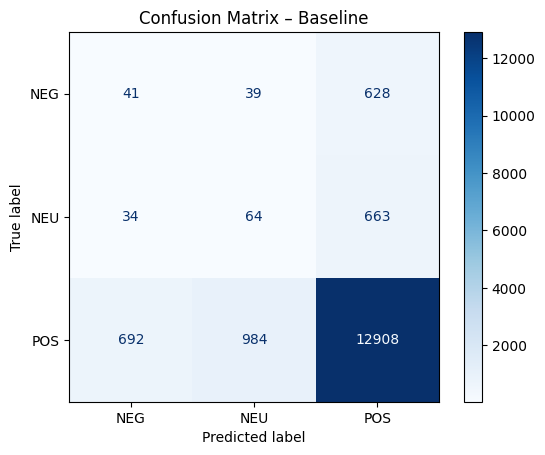

<Figure size 600x500 with 0 Axes>

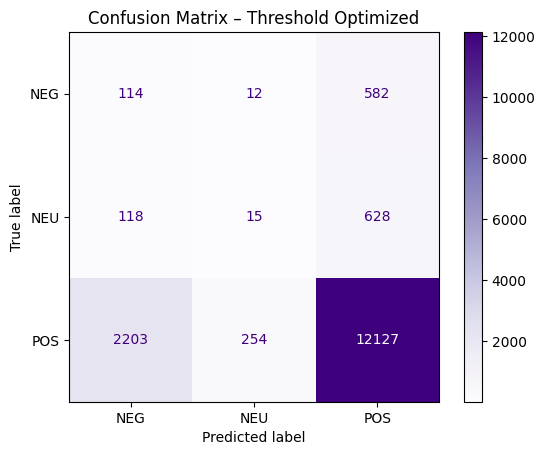


Total predictions changed by thresholding: 1668 of 16053 (10.391%)


In [40]:
# 0) Sanity checks
assert probs.ndim == 2, "probs must be 2D (N, C)."
N, C = probs.shape
assert C == 3, f"Expected 3 classes in probs, got {C}."
assert len(y_pred_idx) == N == len(y_test_enc), "Length mismatch among test arrays."

# 1) Map TRUE labels 5->3 only (preds are already 0/1/2)
map_5to3 = {0:0, 1:0, 2:1, 3:2, 4:2}
y_test_3 = np.array([map_5to3[int(x)] for x in y_test_enc])

# 2) Collect baseline stats
labels3 = ["NEG", "NEU", "POS"]
cm_base = confusion_matrix(y_test_3, y_pred_idx)
print("=== Baseline (no threshold) ===")
print(classification_report(y_test_3, y_pred_idx, target_names=labels3, digits=4))

# 3) Compute negative probs & how many exceed threshold
NEG_IDX = 0  # make sure this is really your negative class index
neg_probs = probs[:, NEG_IDX]
coverage = (neg_probs >= best_threshold).mean()
already_neg = (y_pred_idx == NEG_IDX).mean()
print(f"\nShare with neg_prob >= threshold: {coverage:.3f}")
print(f"Share baseline predicted NEG     : {already_neg:.3f}")

# 4) How many will FLIP under your rule?
will_flip = (neg_probs >= best_threshold) & (y_pred_idx != NEG_IDX)
print(f"Count of predictions that will flip to NEG: {will_flip.sum()} of {N} ({will_flip.mean():.3%})")

# 5) Apply robust decision rule:
#    if neg_prob >= th -> NEG
#    else -> argmax among NON-NEG classes ONLY (so we don’t default back to NEG by global argmax)
y_pred_idx_opt = y_pred_idx.copy()
non_neg_idx = [i for i in range(C) if i != NEG_IDX]

# argmax among non-negative classes for those not forced NEG
non_neg_scores = probs[:, non_neg_idx]  # shape: (N, 2)
non_neg_best = non_neg_scores.argmax(axis=1)
# map back to original class indices (0,1,2)
non_neg_best = np.array([non_neg_idx[j] for j in non_neg_best])

# assign negatives by threshold; others take best non-negative
y_pred_idx_opt[neg_probs >= best_threshold] = NEG_IDX
y_pred_idx_opt[neg_probs <  best_threshold] = non_neg_best[neg_probs < best_threshold]

# 6) Show AFTER stats
cm_opt = confusion_matrix(y_test_3, y_pred_idx_opt)
print("\n=== Threshold-optimized ===")
print(classification_report(y_test_3, y_pred_idx_opt, target_names=labels3, digits=4))

# 7) Visual compare CMs
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=labels3).plot(values_format='d', cmap="Blues")
plt.title("Confusion Matrix – Baseline")
plt.show()

plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=labels3).plot(values_format='d', cmap="Purples")
plt.title("Confusion Matrix – Threshold Optimized")
plt.show()

# 8) Report how many entries changed
changed = (y_pred_idx_opt != y_pred_idx).sum()
print(f"\nTotal predictions changed by thresholding: {changed} of {N} ({changed/N:.3%})")

In [41]:
# THIS IS THE ORIGINAL MODEL PREDS
def pretty_print_report(report_dict):
    # Header
    print(f"{'':>12} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}")

    # Per-class stats
    for lbl in ['0', '1', '2']:
        r = report_dict[lbl]
        print(f"{lbl:>12} {r['precision']:10.4f} {r['recall']:10.4f} {r['f1-score']:10.4f} {int(r['support']):10d}")

    print()  # blank line

    # Accuracy (shifted right for alignment)
    acc = report_dict["accuracy"]
    total_support = int(report_dict["macro avg"]["support"])
    print(f"{'accuracy':>12} {' ':>22}{acc:>10.4f} {total_support:10d}")

    # Macro avg
    macro = report_dict['macro avg']
    print(f"{'macro avg':>12} {macro['precision']:10.4f} {macro['recall']:10.4f} {macro['f1-score']:10.4f} {int(macro['support']):10d}")

    # Weighted avg
    wavg = report_dict['weighted avg']
    print(f"{'weighted avg':>12} {wavg['precision']:10.4f} {wavg['recall']:10.4f} {wavg['f1-score']:10.4f} {int(wavg['support']):10d}")


pretty_print_report(BIGRU_classification_report)


              precision     recall   f1-score    support
           0     0.6675     0.7232     0.6942        708
           1     0.3542     0.5059     0.4167        761
           2     0.9837     0.9577     0.9705      14584

    accuracy                           0.9259      16053
   macro avg     0.6685     0.7289     0.6938      16053
weighted avg     0.9399     0.9259     0.9321      16053


## Balance precision and recall

In [42]:
# ------------ Settings ------------
NEG_IDX = 0               # change if your negative class is a different index
BETA = 1.0                # F_beta; 1.0 = F1. Use >1 to favor recall, <1 to favor precision.
MIN_PRECISION = None      # e.g., 0.50 to require at least 50% precision
MIN_RECALL = None         # e.g., 0.60 to require at least 60% recall

# ------------ Extract neg probs & binary labels ------------
neg_probs = probs[:, NEG_IDX]
y_true_neg = (y_true_idx == NEG_IDX).astype(int)

# ------------ Precision-Recall curve for negative class ------------
prec, rec, thr = precision_recall_curve(y_true_neg, neg_probs)
# precision_recall_curve returns thresholds of length n-1; align arrays:
thr_full = np.r_[0.0, thr]  # prepend a 0.0 threshold for completeness

# ------------ Choose threshold by F_beta (default F1) ------------
# F_beta = (1+beta^2) * (P*R) / (beta^2*P + R)
beta2 = BETA**2
f_beta = (1 + beta2) * (prec * rec) / np.clip(beta2 * prec + rec, 1e-12, None)

# Apply optional operating constraints
valid = np.ones_like(f_beta, dtype=bool)
if MIN_PRECISION is not None:
    valid &= (prec >= MIN_PRECISION)
if MIN_RECALL is not None:
    valid &= (rec >= MIN_RECALL)

if not np.any(valid):
    # fallback: unconstrained best F_beta
    best_idx = np.nanargmax(f_beta)
else:
    best_idx = np.nanargmax(np.where(valid, f_beta, -np.inf))

best_threshold = float(thr_full[best_idx])
best_P, best_R, best_F = float(prec[best_idx]), float(rec[best_idx]), float(f_beta[best_idx])

print(f"[NEG class={NEG_IDX}] Best threshold by F{BETA:.1f}: {best_threshold:.4f} "
      f"(P={best_P:.4f}, R={best_R:.4f}, F{BETA:.1f}={best_F:.4f})")

# ------------ Rebuild multiclass predictions with the new neg threshold ------------
# Rule: if neg_prob >= threshold -> predict NEG; else -> argmax over others
y_pred_idx_opt = y_pred_idx.copy()
for i in range(len(y_pred_idx_opt)):
    if neg_probs[i] >= best_threshold:
        y_pred_idx_opt[i] = NEG_IDX
    else:
        # keep original argmax (or re-argmax excluding NEG if you prefer)
        # y_pred_idx_opt[i] = np.argmax(probs[i])  # equivalent to original argmax
        pass

# ------------ Evaluate ------------
print(classification_report(y_true_idx, y_pred_idx_opt, target_names=[str(x) for x in class_names], digits=4))

[NEG class=0] Best threshold by F1.0: 0.3538 (P=0.6633, R=0.7401, F1.0=0.6996)
              precision    recall  f1-score   support

           0     0.6625    0.7401    0.6991       708
           1     0.3549    0.4967    0.4140       761
           2     0.9837    0.9576    0.9705     14584

    accuracy                         0.9262     16053
   macro avg     0.6670    0.7315    0.6946     16053
weighted avg     0.9398    0.9262    0.9322     16053



In [43]:
NEG_IDX = 0
neg_probs = probs[:, NEG_IDX]
y_true_neg = (y_true_idx == NEG_IDX).astype(int)

# β grid
beta_grid = np.linspace(0.25, 3.0, 12)  # ~12 steps

records = []

for BETA in beta_grid:
    beta2 = BETA**2

    prec, rec, thr = precision_recall_curve(y_true_neg, neg_probs)
    thr_full = np.r_[0.0, thr]

    # Compute Fβ for negative class
    f_beta = (1 + beta2) * (prec * rec) / np.clip(beta2 * prec + rec, 1e-12, None)
    best_idx = np.argmax(f_beta)

    best_threshold = float(thr_full[best_idx])
    best_P = float(prec[best_idx])
    best_R = float(rec[best_idx])
    best_F = float(f_beta[best_idx])

    # Build new predictions
    y_pred_opt = y_pred_idx.copy()
    for i in range(len(y_pred_opt)):
        if neg_probs[i] >= best_threshold:
            y_pred_opt[i] = NEG_IDX
        else:
            pass  # keep original argmax

    report = classification_report(
        y_true_idx,
        y_pred_opt,
        output_dict=True
    )

    # Extract global + negative class metrics
    acc = accuracy_score(y_true_idx, y_pred_opt)
    macro_f1 = f1_score(y_true_idx, y_pred_opt, average="macro")

    neg_prec = report['0']['precision']
    neg_rec = report['0']['recall']

    records.append({
        "beta": BETA,
        "threshold": best_threshold,
        "neg_precision": neg_prec,
        "neg_recall": neg_rec,
        "neg_fbeta": best_F,
        "accuracy": acc,
        "macro_f1": macro_f1,
    })

df_beta = pd.DataFrame(records)
df_beta

,beta,threshold,neg_precision,neg_recall,neg_fbeta,accuracy,macro_f1
0,0.25,0.999327,0.667536,0.723164,0.821922,0.925933,0.693802
1,0.50,0.998396,0.667536,0.723164,0.742964,0.925933,0.693802
2,0.75,0.990926,0.667536,0.723164,0.695378,0.925933,0.693802
3,1.00,0.353826,0.662453,0.740113,0.699599,0.926182,0.694551
4,1.25,0.339772,0.661209,0.741525,0.708339,0.926120,0.694304
5,1.50,0.256882,0.646061,0.752825,0.716694,0.925684,0.690729
6,1.75,0.043612,0.567540,0.795198,0.723965,0.920825,0.666230
7,2.00,0.003430,0.490673,0.854520,0.744341,0.915281,0.640701
8,2.25,0.003430,0.490673,0.854520,0.761549,0.915281,0.640701
9,2.50,0.000971,0.427034,0.896893,0.778845,0.908366,0.611559


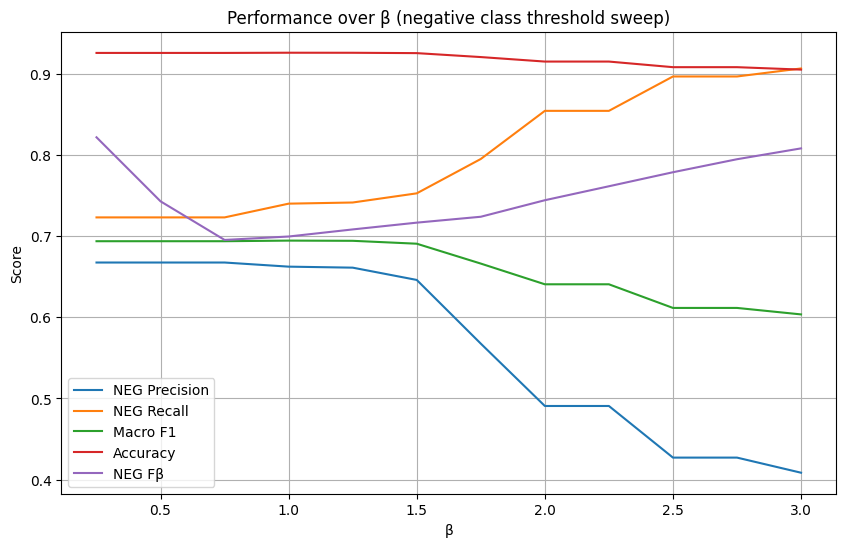

In [44]:
plt.figure(figsize=(10,6))
plt.plot(df_beta["beta"], df_beta["neg_precision"], label="NEG Precision")
plt.plot(df_beta["beta"], df_beta["neg_recall"], label="NEG Recall")
plt.plot(df_beta["beta"], df_beta["macro_f1"], label="Macro F1")
plt.plot(df_beta["beta"], df_beta["accuracy"], label="Accuracy")
plt.plot(df_beta["beta"], df_beta["neg_fbeta"], label="NEG Fβ")

plt.xlabel("β")
plt.ylabel("Score")
plt.title("Performance over β (negative class threshold sweep)")
plt.grid(True)
plt.legend()
plt.show()

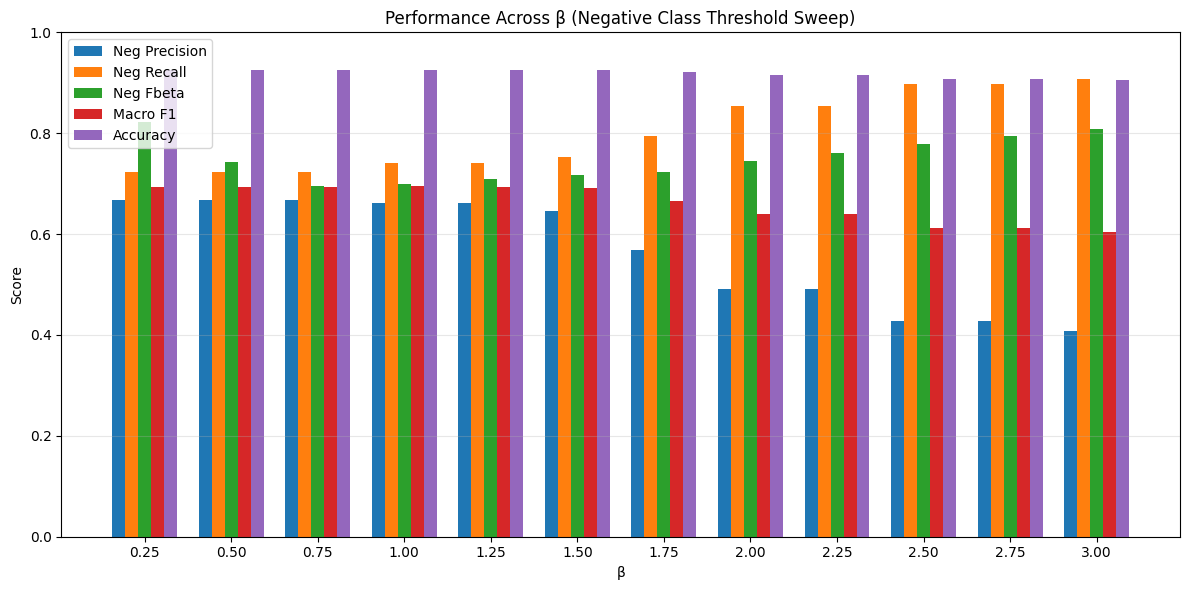

In [45]:
metrics = [
    "neg_precision",
    "neg_recall",
    "neg_fbeta",
    "macro_f1",
    "accuracy"
]

# X positions for each beta
x = np.arange(len(df_beta["beta"]))
bar_width = 0.15   # width of each bar

plt.figure(figsize=(12,6))

for i, m in enumerate(metrics):
    plt.bar(x + i*bar_width, df_beta[m], width=bar_width, label=m.replace("_"," ").title())

# X-tick positions centered
plt.xticks(x + bar_width*2, [f"{b:.2f}" for b in df_beta["beta"]])
plt.xlabel("β")
plt.ylabel("Score")
plt.title("Performance Across β (Negative Class Threshold Sweep)")
plt.ylim(0,1)           # scores between 0–1
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
# Optimize for neg precision
NEG_IDX = 0
MIN_RECALL = 0.60  # set your floor

neg_probs = probs[:, NEG_IDX]
y_true_neg = (y_true_idx == NEG_IDX).astype(int)

prec, rec, thr = precision_recall_curve(y_true_neg, neg_probs)
thr_full = np.r_[0.0, thr]  # align with prec/rec lengths

# Feasible points: recall >= floor
feasible = rec >= MIN_RECALL
if not np.any(feasible):
    print(f"No threshold meets recall ≥ {MIN_RECALL:.2f}. Lower the floor or use Fβ.")
    best_idx = np.argmax(prec)  # fallback: best raw precision
else:
    # Among feasible, pick max precision; if ties, pick with highest recall
    cand_idx = np.where(feasible)[0]
    best_idx = cand_idx[np.lexsort((-rec[cand_idx], prec[cand_idx]))][-1]

best_threshold = float(thr_full[best_idx])
best_P, best_R = float(prec[best_idx]), float(rec[best_idx])

print(f"[NEG] Opt by precision with recall≥{MIN_RECALL:.2f}: "
      f"th={best_threshold:.4f}, P={best_P:.4f}, R={best_R:.4f}")

# Apply to multiclass: if neg_prob >= th => predict NEG else keep original argmax
y_pred_idx_opt = y_pred_idx.copy()
mask_neg = neg_probs >= best_threshold
y_pred_idx_opt[mask_neg] = NEG_IDX

print(classification_report(y_true_idx, y_pred_idx_opt, digits=4))

[NEG] Opt by precision with recall≥0.60: th=0.9842, P=0.7562, R=0.6003
              precision    recall  f1-score   support

           0     0.6675    0.7232    0.6942       708
           1     0.3542    0.5059    0.4167       761
           2     0.9837    0.9577    0.9705     14584

    accuracy                         0.9259     16053
   macro avg     0.6685    0.7289    0.6938     16053
weighted avg     0.9399    0.9259    0.9321     16053



In [47]:
# Target prec
NEG_IDX = 0
TARGET_PRECISION = 0.70  # choose your target precision

neg_probs = probs[:, NEG_IDX]
y_true_neg = (y_true_idx == NEG_IDX).astype(int)

prec, rec, thr = precision_recall_curve(y_true_neg, neg_probs)
thr_full = np.r_[0.0, thr]

# Points that achieve desired precision
meets = prec >= TARGET_PRECISION
if not np.any(meets):
    print(f"No threshold reaches precision ≥ {TARGET_PRECISION:.2f}. Try lowering the target.")
    best_idx = np.argmax(prec)  # fallback: best achievable precision
else:
    # Among those, choose the one with highest recall
    cand_idx = np.where(meets)[0]
    best_idx = cand_idx[np.argmax(rec[cand_idx])]

best_threshold = float(thr_full[best_idx])
best_P, best_R = float(prec[best_idx]), float(rec[best_idx])

print(f"[NEG] Opt for P≥{TARGET_PRECISION:.2f}: th={best_threshold:.4f}, "
      f"P={best_P:.4f}, R={best_R:.4f}")

y_pred_idx_opt = y_pred_idx.copy()
y_pred_idx_opt[neg_probs >= best_threshold] = NEG_IDX

print(classification_report(y_true_idx, y_pred_idx_opt, digits=4))

[NEG] Opt for P≥0.70: th=0.9016, P=0.7005, R=0.6441
              precision    recall  f1-score   support

           0     0.6675    0.7232    0.6942       708
           1     0.3542    0.5059    0.4167       761
           2     0.9837    0.9577    0.9705     14584

    accuracy                         0.9259     16053
   macro avg     0.6685    0.7289    0.6938     16053
weighted avg     0.9399    0.9259    0.9321     16053



In [48]:
df_data = pd.read_csv('./data/reviews.csv')
df_data.head()

,Id,Review,Label
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


In [49]:
X = df_data["Review"]
y = df_data["Label"]


In [50]:
def prepare_splits(X, y, train_size=0.7, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        train_size=train_size,
        random_state=random_state,
        stratify=y
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=random_state,
        stratify=y_temp
    )

    label_enc = LabelEncoder()
    label_enc.fit(list(y_train) + list(y_val) + list(y_test))

    y_train_enc = label_enc.transform(y_train)
    y_val_enc   = label_enc.transform(y_val)
    y_test_enc  = label_enc.transform(y_test)

    print(f" Train: {len(X_train)/len(X):.1%}")
    print(f" Val:   {len(X_val)/len(X):.1%}")
    print(f" Test:  {len(X_test)/len(X):.1%}")
    print("Classes found:", label_enc.classes_)

    return X_train, X_val, X_test, y_train_enc, y_val_enc, y_test_enc, label_enc

In [51]:
X_train, X_val, X_test, y_train_enc, y_val_enc, y_test_enc, label_enc = prepare_splits(X, y)


 Train: 70.0%
 Val:   15.0%
 Test:  15.0%
Classes found: [1 2 3 4 5]


## LDA on Test Set Highly Imbalanced

In [52]:
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(X_test)

topic_model.get_topic_info()
topic_model.visualize_topics()

2025-10-29 01:21:44,020 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/502 [00:00<?, ?it/s]

2025-10-29 01:22:40,324 - BERTopic - Embedding - Completed ✓
2025-10-29 01:22:40,325 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-29 01:23:00,307 - BERTopic - Dimensionality - Completed ✓
2025-10-29 01:23:00,309 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-29 01:23:00,826 - BERTopic - Cluster - Completed ✓
2025-10-29 01:23:00,829 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-29 01:23:01,175 - BERTopic - Representation - Completed ✓


In [53]:
# Vectorize
vectorizer = CountVectorizer(stop_words="english", max_features=20000)
X_test_bow = vectorizer.fit_transform(X_test)

# Fit LDA
lda = LatentDirichletAllocation(
    n_components=10,
    random_state=42
)
lda.fit(X_test_bow)

# Prepare visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, X_test_bow, vectorizer)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.014541 -0.070679       1        1  19.815100
6      0.032902 -0.042888       2        1  13.030006
4     -0.125588  0.023740       3        1  11.318686
9     -0.077143 -0.008193       4        1  10.340804
1     -0.069770  0.096679       5        1   9.671202
0      0.054114  0.010468       6        1   9.642186
7     -0.049888  0.054452       7        1   9.355878
5     -0.032048 -0.081568       8        1   7.268040
2      0.160653  0.137527       9        1   5.028307
3      0.092227 -0.119539      10        1   4.529791, topic_info=              Term         Freq        Total Category  logprob  loglift
5142         great  3517.000000  3517.000000  Default  30.0000  30.0000
5057          good  2984.000000  2984.000000  Default  29.0000  29.0000
6674      learning  1595.000000  1595.000000  Default  28.0000  28.0000
6922           lot  1395.000000  1395.000000  Default  27.0000  27.0000
6971       machine   513.000000   513.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1954         class    36.417227   646.514404  Topic10  -5.4912   0.2179
12243       useful    37.878489   983.176128  Topic10  -5.4518  -0.1619
12582          way    37.085178   935.267740  Topic10  -5.4730  -0.1331
4132     excellent    38.076220  1296.936771  Topic10  -5.4466  -0.4337
5927   informative    31.536456   465.572813  Topic10  -5.6351   0.4024

[798 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1          2  0.832339      01
1          4  0.075667      01
9          1  0.361139      10
9          2  0.124531      10
9          5  0.087171      10
...      ...       ...     ...
12825      3  0.733949     xml
12825      9  0.122325     xml
12829      1  0.272699  yaakov
12829      3  0.727196  yaakov
12841      8  0.855148     yee

[2468 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 5, 10, 2, 1, 8, 6, 3, 4])

In [54]:
# See it is highly imbalanced so we know LDA should be dominated by positive 
y_test_pd = pd.DataFrame(y_test_enc)
y_test_pd.value_counts()

0
4    11876
3     2708
2      761
0      371
1      337
Name: count, dtype: int64

## LDA Pos and Neg From Original Model Preds

In [55]:
y_true_idx = data["y_true_idx"]
y_pred_idx = data["y_pred_idx"]

y_true = data["y_true"]
y_pred = data["y_pred"]

probs = data["probs"]
class_names = data["class_names"]

y_true_idx = np.array(y_true_idx)
y_pred_idx = np.array(y_pred_idx)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

probs = np.array(probs)
class_names = np.array(class_names)



df_test = pd.DataFrame({
    "text": X_test,
    "pred": y_pred_idx    # numeric predictions
})

In [56]:
df_test['pred'].value_counts()

pred
2    14199
1     1087
0      767
Name: count, dtype: int64

In [57]:
NEG_IDX = 0
POS_IDX = 2   # adjust if needed

df_neg = df_test[df_test["pred"] == NEG_IDX].reset_index(drop=True)
df_pos = df_test[df_test["pred"] == POS_IDX].reset_index(drop=True)

print("Neg subset:", len(df_neg))
print("Pos subset:", len(df_pos))

Neg subset: 767
Pos subset: 14199


In [58]:
# POSITIVE subset
X_pos = df_pos["text"]

vectorizer_pos = CountVectorizer(stop_words="english", max_features=20000)
X_pos_bow = vectorizer_pos.fit_transform(X_pos)

lda_pos = LatentDirichletAllocation(
    n_components=8,
    random_state=42
)
lda_pos.fit(X_pos_bow)

pyLDAvis.enable_notebook()
vis_pos = pyLDAvis.lda_model.prepare(lda_pos, X_pos_bow, vectorizer_pos)
vis_pos

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.026908 -0.016948       1        1  26.288896
0     -0.031171 -0.155639       2        1  22.663979
4     -0.071084 -0.032287       3        1  14.702999
1     -0.027359 -0.037093       4        1  10.455017
5     -0.020638  0.028053       5        1   7.158681
7      0.089290 -0.039437       6        1   7.096852
2     -0.171323  0.147697       7        1   7.009548
3      0.205377  0.105655       8        1   4.624029, topic_info=              Term         Freq        Total Category  logprob  loglift
6334      learning  1387.000000  1387.000000  Default  30.0000  30.0000
11608       useful   858.000000   858.000000  Default  29.0000  29.0000
3418          easy   876.000000   876.000000  Default  28.0000  28.0000
4807          good  2614.000000  2614.000000  Default  27.0000  27.0000
5789   interesting  1068.000000  1068.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
8957        really    53.649076  1755.846606   Topic8  -5.0065  -0.4143
8353     practical    36.988377   407.678114   Topic8  -5.3784   0.6740
6571           lot    45.125829  1216.302163   Topic8  -5.1795  -0.2202
10838     teaching    33.831973   354.556902   Topic8  -5.4676   0.7244
3932     excellent    38.567472  1137.130234   Topic8  -5.3366  -0.3100

[623 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1          2  0.077351       01
1          3  0.850866       01
46         6  0.860963     2013
82         1  0.040692       3d
82         2  0.244154       3d
...      ...       ...      ...
12154      1  0.926082   yaakov
12154      6  0.063868   yaakov
12166      6  0.860963      yee
12180      1  0.949416  younger
12192      2  0.933094  youtube

[1606 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 2, 6, 8, 3, 4])

In [59]:
# NEGATIVE subset
X_neg = df_neg["text"]

vectorizer_neg = CountVectorizer(stop_words="english", max_features=20000)
X_neg_bow = vectorizer_neg.fit_transform(X_neg)

lda_neg = LatentDirichletAllocation(
    n_components=8,    # pick topic count
    random_state=42
)
lda_neg.fit(X_neg_bow)

pyLDAvis.enable_notebook()
vis_neg = pyLDAvis.lda_model.prepare(lda_neg, X_neg_bow, vectorizer_neg)
vis_neg

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.049532 -0.086572       1        1  18.338632
6      0.004292 -0.005171       2        1  17.645711
2     -0.023070  0.014450       3        1  11.669681
7      0.102056 -0.000627       4        1  11.651407
5      0.044403 -0.000221       5        1  10.980450
0     -0.102214 -0.088827       6        1  10.282551
3      0.016226  0.101158       7        1  10.078546
1     -0.091224  0.065809       8        1   9.353021, topic_info=             Term        Freq       Total Category  logprob  loglift
899          good  128.000000  128.000000  Default  30.0000  30.0000
913         great  145.000000  145.000000  Default  29.0000  29.0000
960       helpful   29.000000   29.000000  Default  28.0000  28.0000
1086  interesting   50.000000   50.000000  Default  27.0000  27.0000
1193     learning   66.000000   66.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
2247       useful    4.681454   39.039416   Topic8  -5.1522   0.2485
2130        thank    5.137471   65.667538   Topic8  -5.0593  -0.1786
2303          way    3.696121   43.680856   Topic8  -5.3886  -0.1002
2113   techniques    3.144842   11.578391   Topic8  -5.5501   1.0661
2140       things    3.166490   17.029822   Topic8  -5.5432   0.6871

[612 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
9         2  0.821180          2x
20        1  0.823196     ability
21        2  0.419109        able
21        3  0.419109        able
22        5  0.650995  abominable
...     ...       ...         ...
2349      5  0.162888     writing
2349      8  0.162888     writing
2352      6  0.863368       xcode
2355      3  0.855649         yes
2357      1  0.823196        zero

[1228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 3, 8, 6, 1, 4, 2])

## LDA ON ACTUAL NEGATIVE REVIEWS

In [60]:
df_test_true = pd.DataFrame({
    "text": X_test,
    "true": y_test_enc
})

NEG_CLASS_SET = {0, 1}
df_true_neg = df_test_true[df_test_true["true"].isin(NEG_CLASS_SET)]


print("TRUE NEG subset:", len(df_true_neg))

TRUE NEG subset: 708


In [61]:
df_test_true['true'].value_counts()

true
4    11876
3     2708
2      761
0      371
1      337
Name: count, dtype: int64

In [62]:
# Text only
X_true_neg = df_true_neg["text"]

# Vectorize
vec_neg = CountVectorizer(stop_words="english", max_features=20000)
X_true_neg_bow = vec_neg.fit_transform(X_true_neg)

# LDA
lda_neg = LatentDirichletAllocation(
    n_components=8,
    random_state=42
)
lda_neg.fit(X_true_neg_bow)

# Visualize
pyLDAvis.enable_notebook()
vis_neg_true = pyLDAvis.lda_model.prepare(lda_neg, X_true_neg_bow, vec_neg)
vis_neg_true

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.049076 -0.015698       1        1  23.729930
5     -0.051120 -0.015657       2        1  15.976688
0     -0.036974  0.018310       3        1  15.290864
3     -0.052814  0.036767       4        1  11.949656
6     -0.007591 -0.031291       5        1  10.385952
4      0.062097  0.124085       6        1   8.076816
2      0.008556 -0.066690       7        1   7.794717
7      0.126922 -0.049828       8        1   6.795378, topic_info=             Term        Freq       Total Category  logprob  loglift
770        course  645.000000  645.000000  Default  30.0000  30.0000
1943     lectures   95.000000   95.000000  Default  29.0000  29.0000
1872         just  108.000000  108.000000  Default  28.0000  28.0000
277   assignments   79.000000   79.000000  Default  27.0000  27.0000
1972         like  100.000000  100.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
277   assignments    3.863815   79.953173   Topic8  -5.7031  -0.3409
567         class    3.580986   50.782819   Topic8  -5.7791   0.0370
1972         like    3.659080  100.540803   Topic8  -5.7575  -0.6244
1038          don    3.521741   58.397361   Topic8  -5.7958  -0.1194
3799       videos    3.593914   90.808608   Topic8  -5.7755  -0.5406

[628 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2         1  0.287779     10
2         5  0.143889     10
2         6  0.143889     10
2         8  0.431668     10
8         7  0.652084    120
...     ...       ...    ...
3912      1  0.284034  world
3912      3  0.426051  world
3912      4  0.071009  world
3912      5  0.142017  world
3912      6  0.071009  world

[1395 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 4, 7, 5, 3, 8])